**Nonlinear Shrodinger Equation:**<br>
$$
\frac{d}{{dz}}A = {\beta _2}\partial _t^2A + i\alpha A + \gamma {\left| A \right|^2}A  \\
  t \in [0,T);z \in [0,L) 
$$ 
<i>==></i>
\begin{gathered}
  z \to {h^{ - 2}}{\beta _2}z;\alpha  \to {h^2}\alpha /{\beta _2} \hfill \\
  \theta \left( z \right) = \int_0^z {\alpha \left( \zeta  \right)d\zeta }  \hfill \\
  {g_z} = {e^{2\operatorname{Re} \theta \left( z \right)}}sign\left( \gamma  \right) \hfill \\
  {\Psi _n}\left( z \right) = {e^{\theta \left( z \right)}}h{\left( {\frac{{\left| \gamma  \right|}}{{{\beta _2}}}} \right)^{\frac{1}{2}}}A\left( {z,hn} \right) \hfill \\ 
\end{gathered}
<i>==>  Discrete 1D</i>
$$
i\frac{\partial }{{\partial z }}{\Psi_n} = {\Psi_{n + 1}} + {\Psi_{n - 1}} - 2{\Psi_n} +i\alpha \Psi+g |\Psi_n|^2 \Psi_n
$$


In [1]:
# -*- coding: utf-8 -*-

from NLS.brizers import *
from NLS.nls_adapter import *

from plots.asyn_fig import asyn_figure,sprintf
from plots.k3dsurf import surf,cmps,resize

%matplotlib notebook





A=1-1/8
A=1
#A=0.6
A=0.1
N=16*1024*8
NZ=1000;
NZ=200;

mm=256+256;
mm=2;
mm=32
mm=16

omagnus=1
#mm=256;
#omagnus=0
flags=1;

#
flags=0;
alpha=0*1e-8;

sname='nls-exp-dec';
sname='nls';
#sname='nls-magnus-it';
#
sname='ssf';omagnus=0


caption=sprintf("solver=%s $ord_{magnus}=%d$,flags=%d ",sname.upper(),omagnus,flags)


[pT,pZ]=brizerKM_periods(A);
LT=5*abs(pT);
LT=2*abs(pT);
LZ=8/11*2*2.5*abs(pZ);
LZ=8/11*2*2*abs(pZ);
Zoff=-LZ/2

NvT=200;
NvZ=300;
tLv=np.linspace(-LT,LT,NvT);
zLv=np.linspace(-LZ*0,LZ,NvZ);
[TTv,ZZv]=np.meshgrid(tLv,zLv+Zoff);
#figure
#tic


surf(lambda T,Z: np.abs(brizerKM(T,Z,A)),[TTv,ZZv],Xmm=[-1,1],Ymm=[-1,1],axes=['T','z','|\\Psi(T,z)|'],cmp=cmps.twilight_shifted).display()

FFv=brizerKM(TTv,ZZv,A);

surf(FFv.real,[TTv,ZZv],Xmm=[-1,1],Ymm=[-1,1],axes=['T','z','\\Re\\Psi(T,z)']).display()
surf(FFv.imag,[TTv,ZZv],Xmm=[-1,1],Ymm=[-1,1],axes=['T','z','\\Im\\Psi(T,z)']).display()




tt=np.linspace(-LT,LT,N+1);
tt=tt[0:N]
g=1;
[nls,dzu,h]=nls_rescale_to(tt,sname,g);
hz=LZ/NZ; 
dz=hz* dzu/mm

nls.reset(dt=dz,nm=[4,4],omagnus=omagnus,alpha=alpha,w=1/3,flags=flags);




x0=brizerKM(tt,0,A);

nr=np.linalg.norm(x0)*(np.max(tt)-np.min(tt))/N;

z=np.array([Zoff,nr,-np.inf]);

xxr=np.zeros((NZ,N), dtype=complex);
xxe=np.zeros((NZ,N), dtype=complex);





def callback(af,i,A,tt,nls,z,hz,mm):           
    
    global caption,xxr,xxe
    
    
    xe=brizerKM(tt,z[0],A);
    if i==0:
        nls.x=xr=xe;
    else:
        xr=nls(rep=int(mm),pp=1);
        
    tcpu,niter=nls.elapsed;
    
    xxr[i,:]=xr;
    xxe[i,:]=xe;
    
    z[0]+=hz;
    
    
    
    # ====   Grapics ====
    
    
    axr=np.abs(xr);
    axe=np.abs(xe);
    
    af[1](1,(tt,axr),color='#77f',legend='$|\\Psi_{num}|$',linewidth=1.5)
    af[1](2,(tt,axe),color='#00f',legend='$|\\Psi_{an}|$',linewidth=0.5)
    
    af[1](3,(tt,np.real(xr)),color='#3f3',legend='$Re\\Psi_{num}$',linewidth=1.5)
    af[1](4,(tt,np.real(xe)),color='#070',legend='$Re\\Psi_{an}$',linewidth=0.5)
    
    af[1].set_title("[%d] %s elapsed: $\\tau_{cpu}$=%3.3f sec iter=%d",i+1,caption,tcpu,niter)
    
    nr=z[1];
    
    err_r=(np.abs(axr-axe)/nr)**2;
    err_f=(np.abs(xr-xe)/nr)**2;
    
    af[2](0,([tt[0],tt[-1]],[1.,1]),color='#a00',legend='$\epsilon_{cr}=100\%$',linewidth=0.5)
    af[2](1,(tt,err_r),color='#33f',legend='$\\delta\\rho$',linewidth=1.5)
    af[2](2,(tt,err_f),color='#3f3',legend='$\\delta\\Psi$',linewidth=1.5)
    
    
    em=10*np.log10(np.max(err_f));
    if z[2]<em:
        z[2]=em;
    
    af[2].set_title("[%d] $\\epsilon=%3.2f [\\epsilon_{max}:%3.2f][dB]$  ",i+1,em,z[2]);
    
    af[2].set_ylim((1e-12,100))
    

def oncomplete(xxr,NvZ,NvT,TTv,ZZv):
    
    global caption,Zoff
    
    print(caption)
    
    xxv=resize(np.abs(xxr),(NvZ,NvT));
    surf(xxv,[TTv,ZZv],Xmm=[-1,1],Ymm=[-1,1],axes=['T','z','|\\Psi(T,z)|'],title=caption,cmp=cmps.twilight_shifted).display()
    
    xxv=resize(xxr.real,(NvZ,NvT));
    surf(xxv,[TTv,ZZv],Xmm=[-1,1],Ymm=[-1,1],axes=['T','z','\\Re\\Psi(T,z)'],title=caption).display()
    
    xxv=resize(xxr.imag,(NvZ,NvT));
    surf(xxv,[TTv,ZZv],Xmm=[-1,1],Ymm=[-1,1],axes=['T','z','\\Im\\Psi(T,z)'],title=caption).display()
    qr=1./nr
    efxx,drxx=qr*np.abs(xxe-xxr),qr*np.abs(np.abs(xxe)-np.abs(xxr))
    errmin,errmax=efxx.min(1),efxx.max(1);
    rerrmin,rerrmax=drxx.min(1),drxx.max(1);
    zz=hz*np.arange(NZ)+Zoff;
    zmin,zmax=zz.min,zz.max

    fs=asyn_figure(figsize=(10,8))
    fs[1].reset(yscale='log');

    #fs[1].ax.fill_between(zz,errmin, errmax,facecolor='#007',label='$|\delta\Psi|$')
    #fs[1].ax.fill_between(zz,rerrmin, rerrmax,facecolor='#700',label='$|\delta|\Psi||$')
    fs[1].ax.fill_between(zz,errmin, errmax,color='#0a0',facecolor='#005700aa',label='$|\delta\Psi|$')
    fs[1].ax.fill_between(zz,rerrmin, rerrmax,color='#00a',facecolor='#000057aa',label='$|\delta|\Psi||$')
    fs[1].ax.plot([zz[0],zz[-1]],[1.,1],color='#a00',label='100%')
    fs[1].ax.legend(loc='upper left')
    fs[1].ax.set_xlabel('z')
    zmin,zmax=zz.min(),zz.max()
    fs[1].ax.set_xlim(zmin,zmax)
    fs[1].ax.set_ylim(1e-10,1e2)
    fs[1].ax.grid(True,'both')
    edb=20*np.log10(np.max(errmax));
    fs[1].set_title("$\\epsilon_{max}:%3.2f][dB]$  ",edb);

    


af=asyn_figure(figsize=(10,8))
af[1].reset(211);
af[2].reset(212, yscale='log');
print('Start....')

af(NZ,lambda af,i: callback(af,i,A,tt,nls,z,hz,mm)).display();
#af(NZ,lambda af,i: callback(af,i,A,tt,nls,z,hz,mm),lambda : oncomplete(xxr,NvZ,NvT,TTv,ZZv) ).display();

    


pid= 7612
context_wrapper=v:\ipc\py.modules\NLS\bin/ictx/ictxwrr.dll
nls_pade_lib=v:\ipc\py.modules\NLS\bin/nls_pade.dll
ssf_lib=v:\ipc\py.modules\NLS\bin/ssf.dll


Plot(antialias=3, axes=['T', 'z', '|\\Psi(T,z)|'], axes_helper=1.0, background_color=16777215, camera=[2, -3, …

Output()

Plot(antialias=3, axes=['T', 'z', '\\Re\\Psi(T,z)'], axes_helper=1.0, background_color=16777215, camera=[2, -3…

Output()

Plot(antialias=3, axes=['T', 'z', '\\Im\\Psi(T,z)'], axes_helper=1.0, background_color=16777215, camera=[2, -3…

Output()

Start....


solver=NLS $ord_{magnus}=1$,flags=0 


Output()

Output()

Output()

<IPython.core.display.Javascript object>


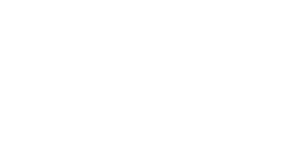

In [9]:
oncomplete(xxr,NvZ,NvT,TTv,ZZv)

solver=NLS $ord_{magnus}=1$,flags=0 


Output()

Output()

Output()

<IPython.core.display.Javascript object>


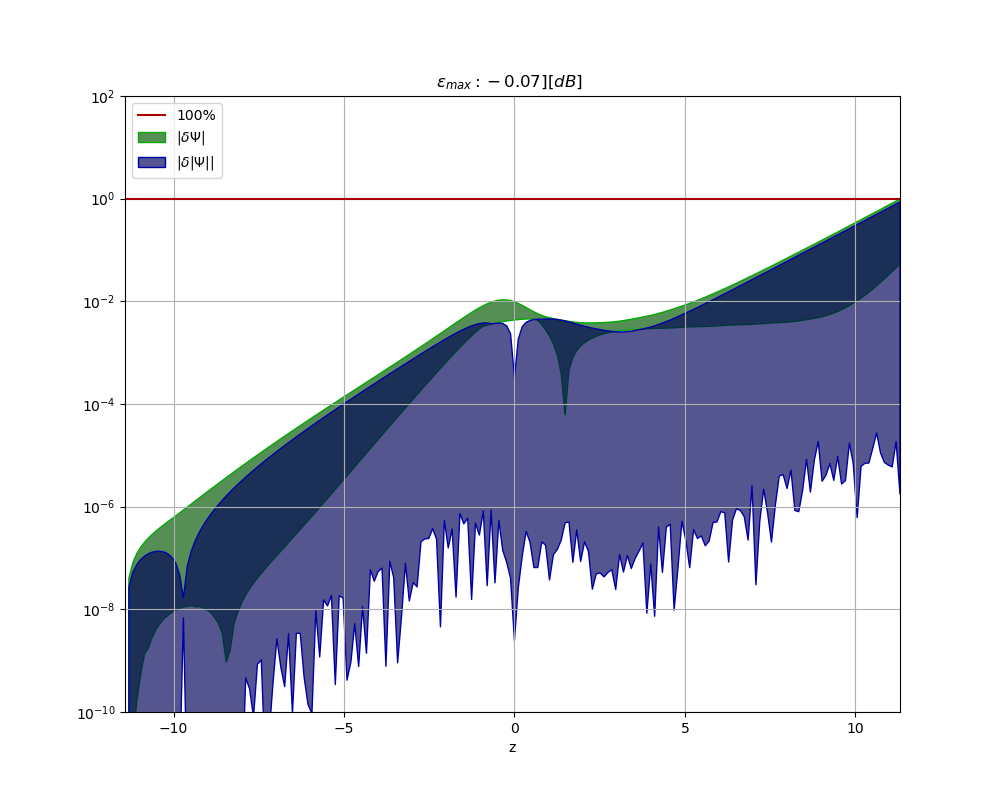

In [17]:
oncomplete(xxr,NvZ,NvT,TTv,ZZv)

In [ ]:
oncomplete(xxr,NvZ,NvT,TTv,ZZv)

In [ ]:
qr=1./nr
efxx,drxx=qr*np.abs(xxe-xxr),qr*np.abs(np.abs(xxe)-np.abs(xxr))
errmin,errmax=efxx.min(1),efxx.max(1);
rerrmin,rerrmax=drxx.min(1),drxx.max(1);
zz=hz*np.arange(NZ);
zmin,zmax=zz.min,zz.max

fs=asyn_figure(figsize=(10,8))
fs[1].reset(yscale='log');

fs[1].ax.fill_between(zz,errmin, errmax,color='#0a0',facecolor='#005700aa',label='$|\delta\Psi|$')
fs[1].ax.fill_between(zz,rerrmin, rerrmax,facecolor='#000057aa',label='$|\delta|\Psi||$')

#fs[1].ax.fill_between(zz,rerrmin, rerrmax,color='#a00',facecolor='#570000aa',label='$|\delta|\Psi||$')
fs[1].ax.legend(loc='upper left')
fs[1].ax.set_xlabel('z')
zmin,zmax=zz.min(),zz.max()
fs[1].ax.set_xlim(zmin,zmax)
fs[1].ax.set_ylim(1e-10,1)
fs[1].ax.grid(True,'both')
edb=10*np.log10(np.max(errmax));
fs[1].set_title("$\\epsilon_{max}:%3.2f][dB]$  ",edb);



In [ ]:
nr

In [ ]:

#fs[1].ax.clear()
fs[1].ax.fill_between(zz,errmin, errmax,facecolor='#007',label='$|\delta|$')
fs[1].ax.fill_between(zz,rerrmin, rerrmax,facecolor='#700',label='rer')
fs[1].ax.legend(loc='upper left')
zmin,zmax=zz.min(),zz.max()
fs[1].ax.set_xlim(zmin,zmax)
fs[1].ax.set_ylim(1e-10,1)
fs[1].ax.grid(True,'both')

In [ ]:
zmax

In [2]:
from NLS.brizers import *

ModuleNotFoundError: No module named 'NLS'

In [6]:
import os;


In [4]:
cd

C:\Users\wwww


In [7]:
os.getcwd()

'C:\\Users\\wwww'

In [5]:
nls.dz

77677.87222459451

In [7]:
nls.g*nls.dz

0.028559933214452663